In [9]:
using ComputationalHeatTransfer
using LaTeXStrings
using Revise
using LinearAlgebra
using DifferentialEquations
using Interpolations
using JLD2
using Plots
gr()  

cd(dirname(pwd()))
cd("src") 
includet("OneDOHP.jl")
using ..OneDOHP

In [10]:
fluid_type = "butane"
Tᵥ = 291.0

291.0

In [11]:
Cpₗ = CoolProp.PropsSI("CPMASS","T",Tᵥ,"Q",0.0,fluid_type)
ρₗ  = CoolProp.PropsSI("D","T",Tᵥ,"Q",0.0,fluid_type)
μₗ  = CoolProp.PropsSI("V","T",Tᵥ,"Q",0.0,fluid_type)
hₗ = CoolProp.PropsSI("H","T",Tᵥ,"Q",0.0,fluid_type)
kₗ = CoolProp.PropsSI("CONDUCTIVITY","T",Tᵥ,"Q",0.0,fluid_type)
Prₗ = CoolProp.PropsSI("PRANDTL","T",Tᵥ,"Q",0.0,fluid_type)

Cpᵥ = CoolProp.PropsSI("CPMASS","T",Tᵥ,"Q",1.0,fluid_type)
ρᵥ  = CoolProp.PropsSI("D","T",Tᵥ,"Q",1.0,fluid_type)
μᵥ  = CoolProp.PropsSI("V","T",Tᵥ,"Q",1.0,fluid_type);
hᵥ = CoolProp.PropsSI("H","T",Tᵥ,"Q",1.0,fluid_type)
kᵥ = CoolProp.PropsSI("CONDUCTIVITY","T",Tᵥ,"Q",1.0,fluid_type)
Prᵥ = CoolProp.PropsSI("PRANDTL","T",Tᵥ,"Q",1.0,fluid_type)

σ = CoolProp.PropsSI("I","T",Tᵥ,"Q",0.0,fluid_type)
P = CoolProp.PropsSI("P","T",Tᵥ,"Q",0.0,fluid_type)
R = CoolProp.PropsSI("GAS_CONSTANT","T",Tᵥ,"Q",1.0,fluid_type)
M = CoolProp.PropsSI("M","T",Tᵥ,"Q",1.0,fluid_type)
Rkg = R/M

αₗ = kₗ/ρₗ/Cpₗ
νₗ = μₗ/ρₗ
νᵥ = μᵥ/ρᵥ;
hₗᵥ = hᵥ-hₗ;

In [61]:
plate_hist, integrator_plate = load("plate_H2250_TH1.5_DirichletBC.jld2", "plate_hist",  "integrator_plate")
sys = integrator_plate.p

Unbounded Heat conduction system on a grid of size 280 x 120 and 0 static immersed points


In [62]:
tube_hist, integrator_tube = load("tube_H2250_TH1.5_DirichletBC.jld2", "tube_hist",  "integrator_tube")

sysfinal = []
for i = 1:length(tube_hist)
    push!(sysfinal, deepcopy(getcurrentsys(tube_hist[i].u,tube_hist[i].p)))
end

┌ Info: Saved animation to 
│   fn = C:\Users\liyux\Documents\GitHub\ComputationalHeatTransfer.jl\src\tmp.gif
└ @ Plots C:\Users\liyux\.julia\packages\Plots\LSKOd\src\animation.jl:114


Plots.AnimatedGif("C:\\Users\\liyux\\Documents\\GitHub\\ComputationalHeatTransfer.jl\\src\\tmp.gif")
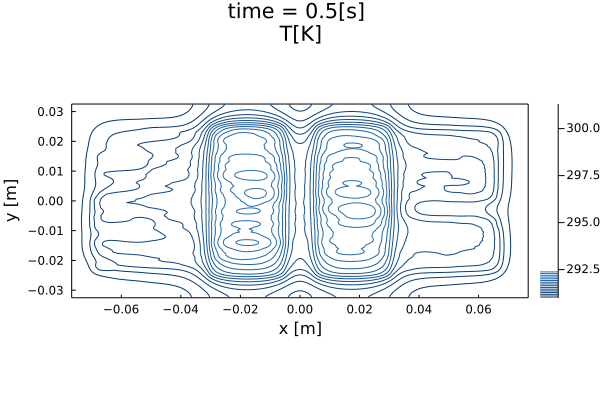

In [63]:
Tmax = maximum(temperature(plate_hist[end-1])[:])
Tmin = minimum(temperature(plate_hist[1])[:])
@gif for i = 1:1:length(plate_hist)
plot(temperature(plate_hist[i]),sys.grid,legend=true,color=cgrad(:RdBu,rev=true),clim=(Tmin,Tmax),line_z=0,xlabel="x [m]",ylabel="y [m]",title=string("time = ", round(plate_hist[i].t, digits=2), "[s] \n",  "T[K]"))
end


In [64]:
savefig("temperature.pdf")

In [112]:
@gif for ii=2:2
#     plot(sysfinal[ii],plottype="T",ylim=(Tmin,Tmax),xlabel="ξ [m]",ylabel="T [K]",xlim=(0.0,0.5))
    plot(sysfinal[ii],plottype="T",ylim=(291.0,293.0),xlabel="ξ [m]",ylabel="T [K]",xlim=(0.0,0.1))
end
savefig("tubetemp.svg")

┌ Info: Saved animation to 
│   fn = C:\Users\liyux\Documents\GitHub\ComputationalHeatTransfer.jl\src\tmp.gif
└ @ Plots C:\Users\liyux\.julia\packages\Plots\LSKOd\src\animation.jl:114


In [66]:
# @gif for ii=1:length(sysfinal)
#     plot(sysfinal[ii],plottype="ΔT",ylim=(-4.0,1.0))
#     plot!([0.0,sysfinal[ii].tube.L],[sysfinal[1].wall.ΔTthres,sysfinal[1].wall.ΔTthres],label="boiling threshold")
# end

┌ Info: Saved animation to 
│   fn = C:\Users\liyux\Documents\GitHub\ComputationalHeatTransfer.jl\src\tmp.gif
└ @ Plots C:\Users\liyux\.julia\packages\Plots\LSKOd\src\animation.jl:114


Plots.AnimatedGif("C:\\Users\\liyux\\Documents\\GitHub\\ComputationalHeatTransfer.jl\\src\\tmp.gif")
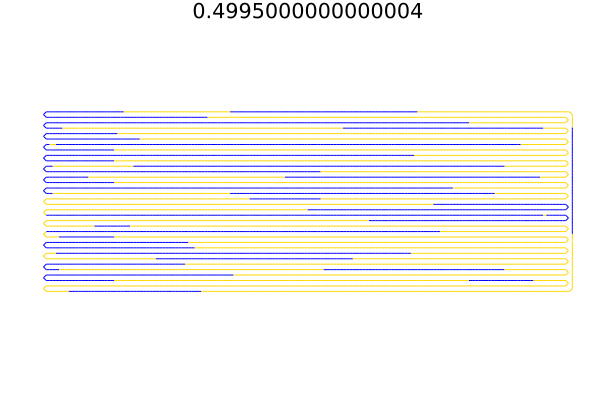

In [67]:
@gif for i=1:1:length(sysfinal)
    Htmp = sys_to_Harray(sysfinal[i])
    plot(sys.qline[1].body,fillalpha=0,linecolor=cgrad([:gold, :blue],rev=true),line_z=Htmp,title=tube_hist[i].t,xlabel="x ",ylabel="y ",border=:none,axis=nothing)
end

In [68]:
# @gif for ii=1:length(sysfinal)
#     plot(sysfinal[ii],plottype="P")
# end

In [11]:
# plot(sys.qline[1].arccoord,sys_to_heatflux(sysfinal[end]))

## get and save tempeature line graph

In [41]:
inch = 2.54e-2;

x = [-3.0inch,0.0]
y = [0.0,0.0]

X =  VectorData(x,y);

In [42]:
H = Regularize(X,cellsize(sys),I0=origin(sys.grid))
g = ScalarData(X);

In [43]:
ghist = []

size(g)
for j = 1:length(g)
    gtemp = []
    for i = 1:length(plate_hist)
        H(g,temperature(plate_hist[i]))
        append!(gtemp,deepcopy(g[j]))
    end
    push!(ghist,deepcopy(gtemp))
end

thist = []
    for i = 1:length(plate_hist)
        append!(thist,plate_hist[i].t)
    end

In [44]:
# save("RTD.jld2","RTDx",RTDx,"RTD1",RTD1,"RTD4",RTD4)

In [45]:
RTDx,RTD1,RTD4 = load("RTD.jld2","RTDx","RTD1","RTD4")

(0:53, [291.2, 291.2, 291.6, 291.8, 292.1, 292.5, 292.7, 293.1, 293.1, 293.6  …  295.8, 295.7, 295.7, 295.9, 295.9, 295.9, 296.1, 295.7, 295.9, 295.9], [291.2, 292.7, 294.0, 295.0, 295.6, 296.3, 296.8, 297.3, 297.7, 298.1  …  301.2, 301.3, 301.4, 301.4, 301.4, 301.5, 301.4, 301.7, 301.6, 301.6])

In [46]:
save("H2250_TH1.5_AdiabaticBC.jld","thist",thist,"ghist",ghist)

## Plot temperature curves

In [47]:
thist_D_5_TH_10,ghist_D_5_TH_10 = load("D_5_TH_10.jld","thist","ghist");

In [48]:
thist_D_03_TH_1,ghist_D_03_TH_1 = load("D_0.3_TH_1.jld","thist","ghist");

In [49]:
thist_D_1_TH_1,ghist_D_1_TH_1 = load("D_1_TH_1.jld","thist","ghist");

In [50]:
thist_D_03_TH_5,ghist_D_03_TH_5 = load("D_0.3_TH_5.jld","thist","ghist");

In [51]:
thist_D_1_TH_1_fixed,ghist_D_1_TH_1_fixed = load("D_1.0_TH_1_fixed.jld","thist","ghist");

In [52]:
thist_D_03_TH_1_fixed,ghist_D_03_TH_1_fixed = load("D_0.3_TH_1_fixed.jld","thist","ghist");

In [53]:
thist_D_10_TH_1_plate_1_h_2250,ghist_D_10_TH_1_plate_1_h_2250 = load("D_1.0_TH_1_plate_1_h_2250.jld","thist","ghist");

In [54]:
thist_D_10_TH_1_plate_15_h_2250,ghist_D_10_TH_1_plate_15_h_2250 = load("D_1.0_TH_1_plate_15_h_2250.jld","thist","ghist");

In [55]:
thist_D_10_TH_1_plate_15_h_2625,ghist_D_10_TH_1_plate_15_h_2625 = load("D_1.0_TH_1_plate_15_h_2625.jld","thist","ghist");

In [56]:
thist_D_10_TH_1_plate_2_h_2250,ghist_D_10_TH_1_plate_2_h_2250 = load("D_1.0_TH_1_plate_2_h_2250.jld","thist","ghist");

In [57]:
thist_H2250_TH15_DirichletBC,ghist_H2250_TH15_DirichletBC = load("plate_H2250_TH15_DirichletBC.jld","thist","ghist");

In [58]:
thist_H2250_TH15_AdiabaticBC,ghist_H2250_TH15_AdiabaticBC = load("H2250_TH1.5_AdiabaticBC.jld","thist","ghist");

In [94]:
# i = 1 #RTD1
i = 2 #RTD4

# plot(thist_D_5_TH_10,ghist_D_5_TH_10[i] .- Tᵥ,label="flim δ/D=0.1, ΔT=10 [K]")
# plot!(thist_D_03_TH_1,ghist_D_03_TH_1[i] .- Tᵥ,label="(incorrect dynamics) flim δ=10 μm, ΔT=0.3 [K]",linewidth=2)
# plot!(thist_D_1_TH_1,ghist_D_1_TH_1[i] .- 295.0,label="(incorrect dynamics) flim δ=10 μm, ΔT=1 [K]",linewidth=2)
# plot!(thist_D_03_TH_5,ghist_D_03_TH_5[i] .-Tᵥ,label="flim δ/D=0.05, ΔT=0.3 [K]")
# plot!(thist_D_1_TH_1_fixed,ghist_D_1_TH_1_fixed[i] .-Tᵥ,label="flim δ=10 μm, ΔT=1.0 [K]",linewidth=2)
# plot(thist_D_03_TH_1_fixed,ghist_D_03_TH_1_fixed[i] .-Tᵥ,label="flim δ=10 μm, ΔT=0.3 [K], Hc = 1500 [W/K], plate d = 2 [mm]",linewidth=2, ylabel="")
# plot!(thist_D_10_TH_1_plate_1_h_2250,ghist_D_10_TH_1_plate_1_h_2250[i] .-Tᵥ,label="flim δ=10 μm, ΔT=1.0 [K], Hc = 2250 [W/K], plate d = 1 [mm]",linewidth=2)
plot(thist_D_10_TH_1_plate_15_h_2250,ghist_D_10_TH_1_plate_15_h_2250[i] .-Tᵥ,label="RTD4 flim δ=10 μm, ΔT=1.0 [K], Hc = 2250 [W/K], plate d = 1.5 [mm]",linewidth=2)
# plot!(thist_D_10_TH_1_plate_2_h_2250,ghist_D_10_TH_1_plate_2_h_2250[i] .-Tᵥ,label="flim δ=10 μm, ΔT=1.0 [K], Hc = 2250 [W/K], plate d = 2 [mm]",linewidth=2)
# plot!(thist_D_10_TH_1_plate_15_h_2625,ghist_D_10_TH_1_plate_15_h_2625[i] .-Tᵥ,label="flim δ=10 μm, ΔT=1.0 [K], Hc = 2625 [W/K], plate d = 1.5 [mm]",linewidth=2)
# plot!(thist_H2250_TH15_DirichletBC,ghist_H2250_TH15_DirichletBC[i] .-Tᵥ,label="DirichletBC",linewidth=2)
# plot!(thist_H2250_TH15_AdiabaticBC,ghist_H2250_TH15_AdiabaticBC[i] .-Tᵥ,label="AdiabaticBC",linewidth=2)
scatter!(RTDx .- RTDx[1],RTD4 .- RTD4[1], label="experiment RTD4",legend=:bottomright)
savefig("RTD4.svg")

In [95]:
i = 1 #RTD1
# i = 2 #RTD4

# plot(thist_D_5_TH_10,ghist_D_5_TH_10[i] .- Tᵥ,label="flim δ/D=0.1, ΔT=10 [K]")
# plot(thist_D_03_TH_1,ghist_D_03_TH_1[i] .- Tᵥ,label="(incorrect dynamics) flim δ=10 μm, ΔT=0.3 [K]",linewidth=2)
# plot!(thist_D_1_TH_1,ghist_D_1_TH_1[i] .- 295.0,label="(incorrect dynamics) flim δ=10 μm, ΔT=1 [K]",linewidth=2)
# plot!(thist_D_03_TH_5,ghist_D_03_TH_5[i] .-Tᵥ,label="flim δ/D=0.05, ΔT=0.3 [K]")
# plot!(thist_D_1_TH_1_fixed,ghist_D_1_TH_1_fixed[i] .-Tᵥ,label="flim δ=10 μm, ΔT=1.0 [K]",linewidth=2)
# plot(thist_D_03_TH_1_fixed,ghist_D_03_TH_1_fixed[i] .-Tᵥ,label="flim δ=10 μm, ΔT=0.3 [K], Hc = 1500 [W/K], plate d = 2 [mm]",linewidth=2)
# plot!(thist_D_10_TH_1_plate_1_h_2250,ghist_D_10_TH_1_plate_1_h_2250[i] .-Tᵥ,label="flim δ=10 μm, ΔT=1.0 [K], Hc = 2250 [W/K], plate d = 1 [mm]",linewidth=2)
plot!(thist_D_10_TH_1_plate_15_h_2250,ghist_D_10_TH_1_plate_15_h_2250[i] .-Tᵥ,label="RTD1 flim δ=10 μm, ΔT=1.0 [K], Hc = 2250 [W/K], plate d = 1.5 [mm]",linewidth=2)
# plot!(thist_D_10_TH_1_plate_2_h_2250,ghist_D_10_TH_1_plate_2_h_2250[i] .-Tᵥ,label="flim δ=10 μm, ΔT=1.0 [K], Hc = 2250 [W/K], plate d = 2 [mm]",linewidth=2)
# plot!(thist_D_10_TH_1_plate_15_h_2625,ghist_D_10_TH_1_plate_15_h_2625[i] .-Tᵥ,label="flim δ=10 μm, ΔT=1.0 [K], Hc = 2625 [W/K], plate d = 1.5 [mm]",linewidth=2)
# plot!(thist_H2250_TH15_DirichletBC,ghist_H2250_TH15_DirichletBC[i] .-Tᵥ,label="flim δ=10 μm, ΔT=1.0 [K]",linewidth=2)
# plot!(thist_H2250_TH15_AdiabaticBC,ghist_H2250_TH15_AdiabaticBC[i] .-Tᵥ,label="flim δ=10 μm, ΔT=1.0 [K]",linewidth=2)
scatter!(RTDx .- RTDx[1],RTD1 .- RTD1[1], label="experiment RTD1",legend=:topright,ylim=(0.0,15.0),xlabel="t [s]",ylabel="T-T₀ [K]")
savefig("RTD1.svg")

In [32]:
sysfinal[end].vapor.δ[1]

1.0e-5

In [33]:
sysfinal[end].wall.ΔTthres

1.0

## OHP animation

In [34]:
ρ = 2700;
c = 8.97e02;
k = 1.67e02;
d = 2e-3;
params = HeatConductionParameters(ρ,c,k,thickness=d)

HeatConductionParameters(2700.0, 897.0, 167.0, 6.895412692514142e-5, 0.002)

In [35]:
Δx = cellsize(sys)
ds = 1.5Δx
nturn = 16
#pitch = 0.125
length_ohp = 44.25*1e-3
height = 133.83*1e-3
gap = d
pitch = length_ohp/(2*nturn+1)
x0, y0 = height/2, length_ohp/2
x, y, xf, yf = ComputationalHeatTransfer.construct_ohp_curve(nturn,pitch,height,gap,ds,x0,y0,false,false,3pi/2)
ohp = BasicBody(x,y)

Basic pointwise-specified body with 5598 points
   Current position: (0.0,0.0)
   Current angle (rad): 0.0


In [36]:
sys.points

0 points of vector-valued Float64 data
Float64[]

┌ Info: Saved animation to 
│   fn = C:\Users\liyux\Documents\GitHub\ComputationalHeatTransfer.jl\src\tmp.gif
└ @ Plots C:\Users\liyux\.julia\packages\Plots\LSKOd\src\animation.jl:114


Plots.AnimatedGif("C:\\Users\\liyux\\Documents\\GitHub\\ComputationalHeatTransfer.jl\\src\\tmp.gif")
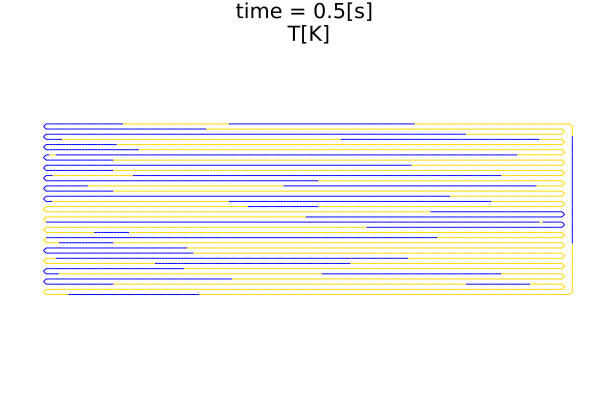

In [37]:
@gif for i=1:1:length(sysfinal)
    Htmp = sys_to_Harray(sysfinal[i])
    plot(ohp,fillalpha=0,linecolor=cgrad([:gold, :blue],rev=true),line_z=Htmp,xlabel="x ",ylabel="y ",border=:none,axis=nothing,title=string("time = ", round(plate_hist[i].t, digits=2), "[s] \n",  "T[K]"))
end

## OHP film thickness correlation

In [38]:
integrator_tube.p.vapor.δ

30-element Array{Float64,1}:
 1.0e-5
 1.0e-5
 1.0e-5
 1.0e-5
 1.0e-5
 1.0e-5
 1.0e-5
 1.0e-5
 1.0e-5
 1.0e-5
 1.0e-5
 1.0e-5
 1.0e-5
 ⋮
 1.0e-5
 1.0e-5
 1.0e-5
 1.0e-5
 1.0e-5
 1.0e-5
 1.0e-5
 1.0e-5
 1.0e-5
 1.0e-5
 1.0e-5
 1.0e-5

In [54]:

velocity_avg = zeros(length(sysfinal))
velocity_max = zeros(length(sysfinal))

for i = 1:length(sysfinal)
    tmp = 0
    for j = length(sysfinal[i].liquid.dXdt)
        tmp += abs(sysfinal[i].liquid.dXdt[j][1])
    
        velocity_avg[i] = tmp/j
    end
    
    velocity_max[i] = maximum(abs.(sysfinal[i].liquid.dXdt[:][1]))
end



In [40]:
μₗ

0.0001696329111597828

In [41]:
Ca = a .* μₗ ./σ

LoadError: [91mUndefVarError: a not defined[39m

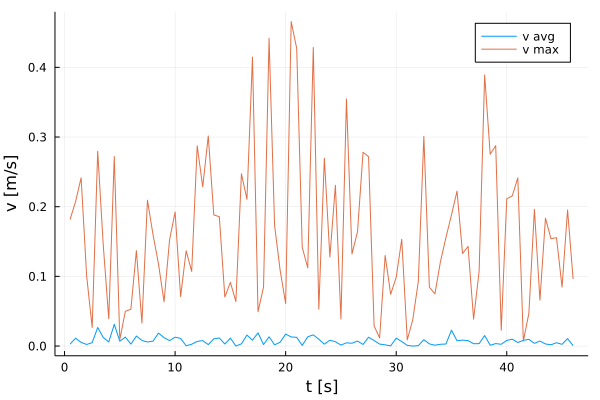

In [59]:
plot(thist,velocity_avg,label="v avg")
plot!(thist,velocity_max,label="v max",xlabel="t [s]", ylabel="v [m/s]")

In [66]:
d_tube = sysfinal[end].tube.d

0.001

### Range of Re
### $Re = \frac{\rho_{\mathrm{l}} v d}{\mu_{\mathrm{l}}}$



In [75]:
Re_avg = d_tube*ρₗ .* velocity_avg / μₗ
Re_max = d_tube*ρₗ .* velocity_max / μₗ;

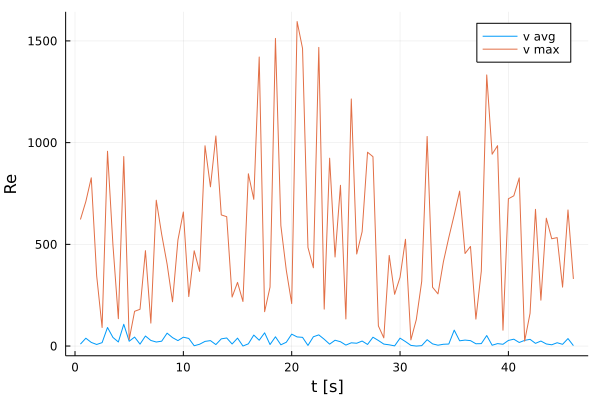

In [74]:
plot(thist,Re_avg,label="v avg")
plot!(thist,Re_max,label="v max",xlabel="t [s]", ylabel="Re")

In [43]:
integrator_tube.p.vapor.δ

30-element Array{Float64,1}:
 1.0e-5
 1.0e-5
 1.0e-5
 1.0e-5
 1.0e-5
 1.0e-5
 1.0e-5
 1.0e-5
 1.0e-5
 1.0e-5
 1.0e-5
 1.0e-5
 1.0e-5
 ⋮
 1.0e-5
 1.0e-5
 1.0e-5
 1.0e-5
 1.0e-5
 1.0e-5
 1.0e-5
 1.0e-5
 1.0e-5
 1.0e-5
 1.0e-5
 1.0e-5

In [44]:
δ_corr = integrator_tube.p.tube.d * (0.67 .* Ca.^(2/3)) ./ ( 1 .+ 3.35 .* Ca.^(2/3))

LoadError: [91mUndefVarError: Ca not defined[39m

In [45]:
δ_corr = integrator_tube.p.tube.d * (0.67 .* Ca2.^(2/3)) ./ ( 1 .+ 3.35 .* Ca2.^(2/3))

LoadError: [91mUndefVarError: Ca2 not defined[39m

In [46]:
U = 0.15 #m/s

Ca2 = U .* μₗ ./σ

0.001997674052132908

In [47]:
sysfinal[1].wall.ΔTthres

1.0

In [48]:
sysfinal[1].vapor.δ

30-element Array{Float64,1}:
 1.0e-5
 1.0e-5
 1.0e-5
 1.0e-5
 1.0e-5
 1.0e-5
 1.0e-5
 1.0e-5
 1.0e-5
 1.0e-5
 1.0e-5
 1.0e-5
 1.0e-5
 ⋮
 1.0e-5
 1.0e-5
 1.0e-5
 1.0e-5
 1.0e-5
 1.0e-5
 1.0e-5
 1.0e-5
 1.0e-5
 1.0e-5
 1.0e-5
 1.0e-5